In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
    print(os.path.join(dirname))#, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/wlasl-processed
/kaggle/input/wlasl-processed/videos
/kaggle/input/helper


In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 34.7 MB/s eta 0:00:00


In [3]:
import cv2
import mediapipe as mp
import json
import time
import sys
import urllib.request
import random
import logging

from multiprocessing.dummy import Pool
from pathlib import Path
import matplotlib.pyplot as plt


# from tdqm import tdqm

In [4]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


**Read the JSON File**

In [5]:
json_path = '/kaggle/input/wlasl-processed/WLASL_v0.3.json'

with open(json_path) as ipf:
    content = json.load(ipf)
 
#initialise counts for subsets
count_train = 0
count_val = 0
count_test = 0

#read the json
for entity in content:
    gloss = entity['gloss']
    
    for inst in entity['instances']:
        split = inst['split']
        
        if split == 'train':
            count_train += 1
        elif split == 'test':
            count_test += 1
        elif split == 'val':
            count_val += 1
        else:
            raise ValueError('Error: Invalid split.')

            
print(f'Total glosses(labels): {len(content)}')
print(f'Total samples: train:{count_train}, val:{count_val}, test:{count_test}')

Total glosses(labels): 2000
Total samples: train:14289, val:3916, test:2878


In [6]:
def parse_json(): #converts the json file into a pandas datatype
    
    
    jsonpath = "/kaggle/input/wlasl-processed/WLASL_v0.3.json"#json path
    
    #open json file as list of dictionaries
    with open(jsonpath) as data_file:    
        data = json.load(data_file)  
        
    header = ["gloss"]
    

    datakey = data[0]["instances"][0].keys() #create the column heads 
    for h in datakey:
        header.append(h)

    
    df = pd.DataFrame(columns=header,dtype = object)#create an empty dataframe
    
    gloss_list = [d["gloss"] for d in data] #get list of glosses
    
    #iterate every gloss in the list and apend every video of that gloss
    for i in range(len(gloss_list)):
        gloss = gloss_list[i]
        instances = data[i]["instances"] #list of instances
        for j in range(len(instances)): #iterate over every instance
            entry = instances[j]
            entry["gloss"] = gloss
            df = df.append(entry,ignore_index=True)
    return (df, gloss_list) 

#uncomment the following if json has not been parsed
df, gloss_list,  = parse_json()
    #open json file as list of dictionaries

#comment the following lines if json not has been parsed
#with open('WLASL_v0.3.json') as data_file:    
#        data = json.load(data_file)  
#gloss_list = [d["gloss"] for d in data] #get list of glosses


In [7]:
raw_vid_path = "/kaggle/input/wlasl-processed/videos"#path of the raw video folder

vid_paths = os.listdir(raw_vid_path)


#remove video clips that are not integers and remove file extension
#vid_paths = [Path(path).stem for path in vid_paths if isdigit(Path(path).stem)]
vid_paths = [Path(path).stem for path in vid_paths]

vid_id = pd.DataFrame(vid_paths,columns=["video_id"],dtype=object)#create an empty dataframe

#get intersection
clean_df = pd.merge(vid_id,df,how="inner",on=["video_id"])

In [8]:
clean_df.tail()


,video_id,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id
11975,32388,laugh,"[64, 25, 208, 192]",25,-1,1,20,10,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/22/2229...,1
11976,40117,orange,"[910, 68, 1734, 1056]",25,-1,1,8,39,signschool,train,https://signstock.blob.core.windows.net/signsc...,0
11977,53670,specific,"[74, 17, 197, 192]",25,-1,1,4,10,signingsavvy,val,https://www.signingsavvy.com/signs/mp4/24/2408...,0
11978,33768,lonely,"[138, 0, 519, 480]",25,-1,1,5,13,asldeafined,val,https://media.asldeafined.com/vocabulary/14687...,0
11979,62113,wait,"[202, 52, 558, 400]",25,-1,1,1,12,aslsearch,test,http://www.aslsearch.com/signs/videos/stall.mp4,0


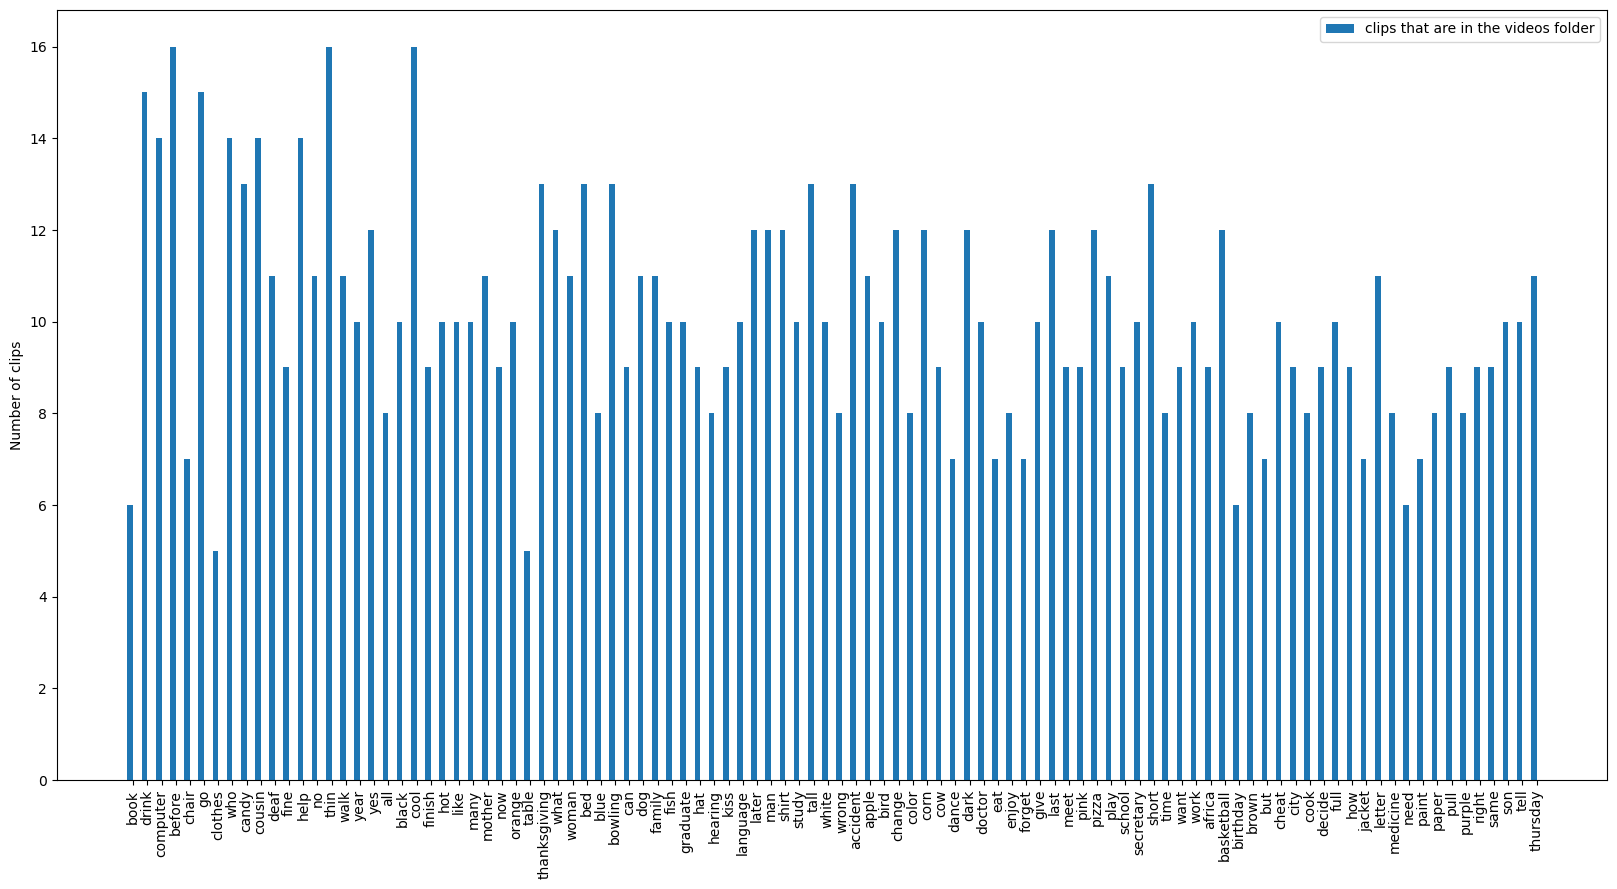

In [9]:
clean_samples = []
clean_df["gloss"] = clean_df["gloss"].astype("str")

for i in range(100):
    clean_samples.append(clean_df["gloss"].value_counts()[gloss_list[i]])
#     og_samples.append(df["gloss"].value_counts()[gloss_list[i]])

fig, ax = plt.subplots(figsize = [20,10])

Xval = np.arange(100)

plt.xticks(range(100),gloss_list[:100],rotation = 90)
rects1 = ax.bar(Xval-0.2,clean_samples,0.4, label="clips that are in the videos folder")
# rects2 = ax.bar(Xval+0.2,og_samples,0.4,label="clips that are in the Json")

plt.ylabel("Number of clips")


plt.legend()
plt.show()

In [10]:
clean_samples

[6,
 15,
 14,
 16,
 7,
 15,
 5,
 14,
 13,
 14,
 11,
 9,
 14,
 11,
 16,
 11,
 10,
 12,
 8,
 10,
 16,
 9,
 10,
 10,
 10,
 11,
 9,
 10,
 5,
 13,
 12,
 11,
 13,
 8,
 13,
 9,
 11,
 11,
 10,
 10,
 9,
 8,
 9,
 10,
 12,
 12,
 12,
 10,
 13,
 10,
 8,
 13,
 11,
 10,
 12,
 8,
 12,
 9,
 7,
 12,
 10,
 7,
 8,
 7,
 10,
 12,
 9,
 9,
 12,
 11,
 9,
 10,
 13,
 8,
 9,
 10,
 9,
 12,
 6,
 8,
 7,
 10,
 9,
 8,
 9,
 10,
 9,
 7,
 11,
 8,
 6,
 7,
 8,
 9,
 8,
 9,
 9,
 10,
 10,
 11]

**Download the raw videos**

In [11]:
logging.basicConfig(filename='download_{}.log'.format(int(time.time())), filemode='w', level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))


In [12]:
def request_video(url, referer=''):
    print('requesting video')
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers = {'User-Agent': user_agent,
              }
    
    if referer:
        headers['Referer'] = referer
    
    #assemble the request
    request = urllib.request.Request(url,None, headers)
    
    logging.info(f'Requesting {url}')
    response = urllib.request.urlopen(request)
    data = response.read()
    print('requested video')
    return data

In [13]:
def save_video(data, saveto):
    print('saving video')
    with open(saveto, 'wb+') as f:
        f.write(data)


    time.sleep(random.uniform(0.5, 1.5))
    print('saved video')

In [14]:
def download_youtube(url, dirname, video_id):
    raise NotImplementedError('Urllib cant deal with this link')

In [15]:
def download_aslpro(url, dirname, video_id):
    saveto = os.path.join(dirname, '{}.swf'.format(video_id))
    if os.path.exists(saveto):
        logging.info('{} exists at {}'.format(video_id, saveto))
        return
    
    data = request_video(url, referer='http://www.aslpro.com/cgi-bin/aslpro/aslpro.cgi')
    save_video(data, saveto)
    print('downloaded asl video')

In [16]:
def download_others(url, dirname, video_id):
    saveto = os.path.join(dirname, '{}.mp4'.format(video_id))
    if os.path.exists(saveto):
        logging.info(f'{video_id} exists at {saveto}')
        return
    
    data = request_videos(url)
    save_video(data, saveto)
    print('downloaded other video')

In [17]:
# Choose the appropriate download method based on the url
def select_download_method(url):
    if 'aslpro' in url:
        return download_aslpro
    elif 'youtube' in url or 'youtu.be' in url:
        return download_youtube
    else: 
        return download_others

In [18]:
def download_nonyt_videos(indexfile, saveto='raw_videos'):
    content = json.load(open(indexfile))
    
    if not os.path.exists(saveto):
        os.mkdir(saveto)
        
    for entry in content[:100]:
        gloss = entry['gloss']
        instances = entry['instances']
        
        for inst in instances:
            video_url = inst['url']
            video_id = inst['video_id']
            
            logging.info(f'gloss: {gloss}, video: {video_id}')
            
            download_method = select_download_method(video_url)
            
            if download_method == download_youtube:
                logging.warning(f'Skipping YouTube video {video_id}')
                continue
            
            try:
                download_method(video_url,saveto, video_id)
            except Exception as e:
                logging.error(f'Unsuccesful downloading - video {video_id}, url: {video_url}')    

In [19]:
def check_youtube_dl_version():
    print('checking yt version')
    ver = os.popen('youtube-dl --version').read()

    assert ver, "youtube-dl cannot be found in PATH. Please verify your installation."
    assert ver >= '2020.03.08', "Please update youtube-dl to newest version."


In [20]:
def download_yt_videos(indexfile, saveto='/kaggle/input/wlasl-processed/videos'):
    print('download yt vid')
    content = json.load(open(indexfile))
    
    if not os.path.exists(saveto):
        os.mkdir(saveto)
    count = 20
    for entry in content[:100]:
        if count == 0:
            return
        count = count -1
        gloss = entry['gloss']
        instances = entry['instances']

        for inst in instances:
            video_url = inst['url']
            video_id = inst['video_id']

            if 'youtube' not in video_url and 'youtu.be' not in video_url:
                continue

            if os.path.exists(os.path.join(saveto, video_url[-11:] + '.mp4')) or os.path.exists(os.path.join(saveto, video_url[-11:] + '.mkv')):
                logging.info('YouTube videos {} already exists.'.format(video_url))
                continue
            else:
                cmd = "youtube-dl \"{}\" -o \"{}%(id)s.%(ext)s\""
                cmd = cmd.format(video_url, saveto + os.path.sep)

                rv = os.system(cmd)
                
                if not rv:
                    logging.info('Finish downloading youtube video url {}'.format(video_url))
                else:
                    logging.error('Unsuccessful downloading - youtube video url {}'.format(video_url))

                # please be nice to the host - take pauses and avoid spamming
                time.sleep(random.uniform(1.0, 1.5))
                

In [21]:
# logging.info('Start downloading non-youtube videos.')
# download_nonyt_videos('/kaggle/input/wlasl-processed/WLASL_v0.3.json')

# check_youtube_dl_version()
# logging.info('Start downloading youtube videos.')
# download_yt_videos('/kaggle/input/wlasl-processed/WLASL_v0.3.json')

**Preprocess the raw videos**

In [22]:
# # preprocessing script for WLASL dataset
# # 1. Convert .swf, .mkv file to mp4.
# # 2. Extract YouTube frames and create video instances.

# import os
# import json
# import cv2

# import shutil

# def convert_everything_to_mp4():
#     cmd = 'bash /kaggle/input/helper/swf2mp4.sh'

#     os.system(cmd)


# def video_to_frames(video_path, size=None):
#     """
#     video_path -> str, path to video.
#     size -> (int, int), width, height.
#     """

#     cap = cv2.VideoCapture(video_path)

#     frames = []
    
#     while True:
#         ret, frame = cap.read()
    
#         if ret:
#             if size:
#                 frame = cv2.resize(frame, size)
#             frames.append(frame)
#         else:
#             break

#     cap.release()

#     return frames


# def convert_frames_to_video(frame_array, path_out, size, fps=25):
#     out = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

#     for i in range(len(frame_array)):
#         # writing to a image array
#         out.write(frame_array[i])
#     out.release()


# def extract_frame_as_video(src_video_path, start_frame, end_frame):
#     frames = video_to_frames(src_video_path)

#     return frames[start_frame: end_frame+1]


# def extract_all_yt_instances(content):
#     cnt = 1

#     if not os.path.exists('videos'):
#         os.mkdir('videos')

#     for entry in content:
#         instances = entry['instances']

#         for inst in instances:
#             url = inst['url']
#             video_id = inst['video_id']

#             if 'youtube' in url or 'youtu.be' in url:
#                 cnt += 1
                
#                 yt_identifier = url[-11:]

#                 src_video_path = os.path.join('raw_videos_mp4', yt_identifier + '.mp4')
#                 dst_video_path = os.path.join('videos', video_id + '.mp4')

#                 if not os.path.exists(src_video_path):
#                     continue

#                 if os.path.exists(dst_video_path):
#                     print('{} exists.'.format(dst_video_path))
#                     continue

#                 # because the JSON file indexes from 1.
#                 start_frame = inst['frame_start'] - 1
#                 end_frame = inst['frame_end'] - 1

#                 if end_frame <= 0:
#                     shutil.copyfile(src_video_path, dst_video_path)
#                     continue

#                 selected_frames = extract_frame_as_video(src_video_path, start_frame, end_frame)
                
#                 # when OpenCV reads an image, it returns size in (h, w, c)
#                 # when OpenCV creates a writer, it requres size in (w, h).
#                 size = selected_frames[0].shape[:2][::-1]
                
#                 convert_frames_to_video(selected_frames, dst_video_path, size)

#                 print(cnt, dst_video_path)
#             else:
#                 cnt += 1

#                 src_video_path = os.path.join('raw_videos_mp4', video_id + '.mp4')
#                 dst_video_path = os.path.join('videos', video_id + '.mp4')

#                 if os.path.exists(dst_video_path):
#                     print('{} exists.'.format(dst_video_path))
#                     continue

#                 if not os.path.exists(src_video_path):
#                     continue

#                 print(cnt, dst_video_path)
#                 shutil.copyfile(src_video_path, dst_video_path)


# def main():
#     # 1. Convert .swf, .mkv file to mp4.
#     convert_everything_to_mp4()

#     content = json.load(open('/kaggle/input/wlasl-processed/WLASL_v0.3.json'))
#     extract_all_yt_instances(content)


# if __name__ == "__main__":
#     main()